In [1]:
import numpy as np
import torch, os
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from hyper_sl.utils import data_process

In [3]:
def load_occ(i):
        """
        bring occlusion map

        input i-th scene occlusion map

        return occlusion map in tensor type

        """
        cam_H, cam_W = 580, 890
        output_dir = "/workspace/Scalable-Hyperspectral-3D-Imaging/dataset/data/result_np"
        occlusion = np.load(os.path.join(output_dir, "scene_%04d_Occlusion.npy" %(i))).astype(np.float32)
        occlusion = data_process.crop(occlusion)
        occlusion = torch.tensor(occlusion)
        occlusion = occlusion.reshape(cam_H*cam_W,3)

        # threshold
        mask_0 = (occlusion[:,:] <= 0.8)  #  0.5보다 작은 숫자들 즉, true 인 곳에 0을 넣기
        mask_1 = (occlusion[:,:] > 0.8)

        occ = np.ma.array(occlusion, mask=mask_0)
        occ = occ.filled(fill_value=0.0)

        occ = np.ma.array(occ, mask=mask_1)
        occ = occ.filled(fill_value=1.0)

        occ = occ.reshape(cam_H, cam_W,3)
        occ = occ[...,0]
        occ = torch.tensor(occ)

        return occ

In [4]:
# set dimensions
R, C = 890, 580  # width, height
N = 40  # number of illumination patterns
W = 25  # number of wavelengths
M = R * C  # number of total elements in A and B

# R, C = 640, 640  # width, height
# N = 42  # number of illumination patterns
# W = 29  # number of wavelengths
# M = R * C  # number of total elements in A and B

In [5]:
pred_hyp = np.load('/workspace/Scalable-Hyperspectral-3D-Imaging/prediction/prediction_hyp_1530.npy')
gt_hyp = np.load('/workspace/Scalable-Hyperspectral-3D-Imaging/prediction/ground_truth_hyp_1530.npy')

In [6]:
pred_hyp = pred_hyp.reshape(C,R,W)
gt_hyp = gt_hyp.reshape(C,R,W)

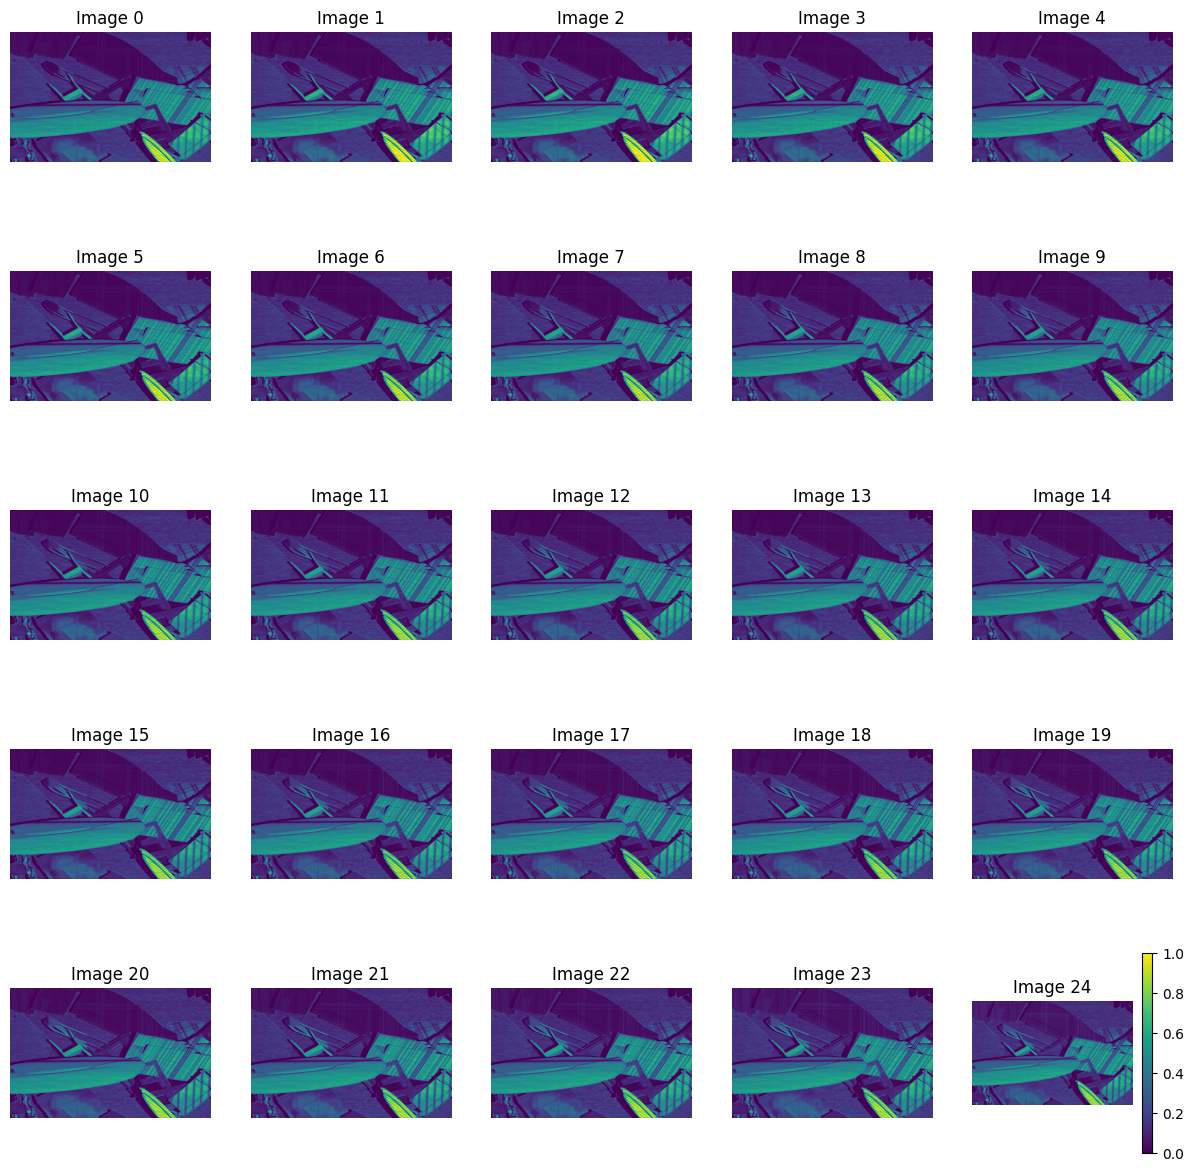

In [7]:
max_images_per_column = 5
num_columns = (W + max_images_per_column - 1) // max_images_per_column
plt.figure(figsize=(15, 3*num_columns))

for c in range(num_columns):
    start_index = c * max_images_per_column
    end_index = min(start_index + max_images_per_column, W)
    num_images = end_index - start_index
    
    for i in range(num_images):
        plt.subplot(num_columns, num_images, i + c * num_images + 1)
        plt.imshow(pred_hyp[:, :, i + start_index], vmin=0, vmax=1)
        plt.axis('off')
        plt.title(f"Image {i + start_index}")
        
        if i + start_index == W - 1:
            plt.colorbar()

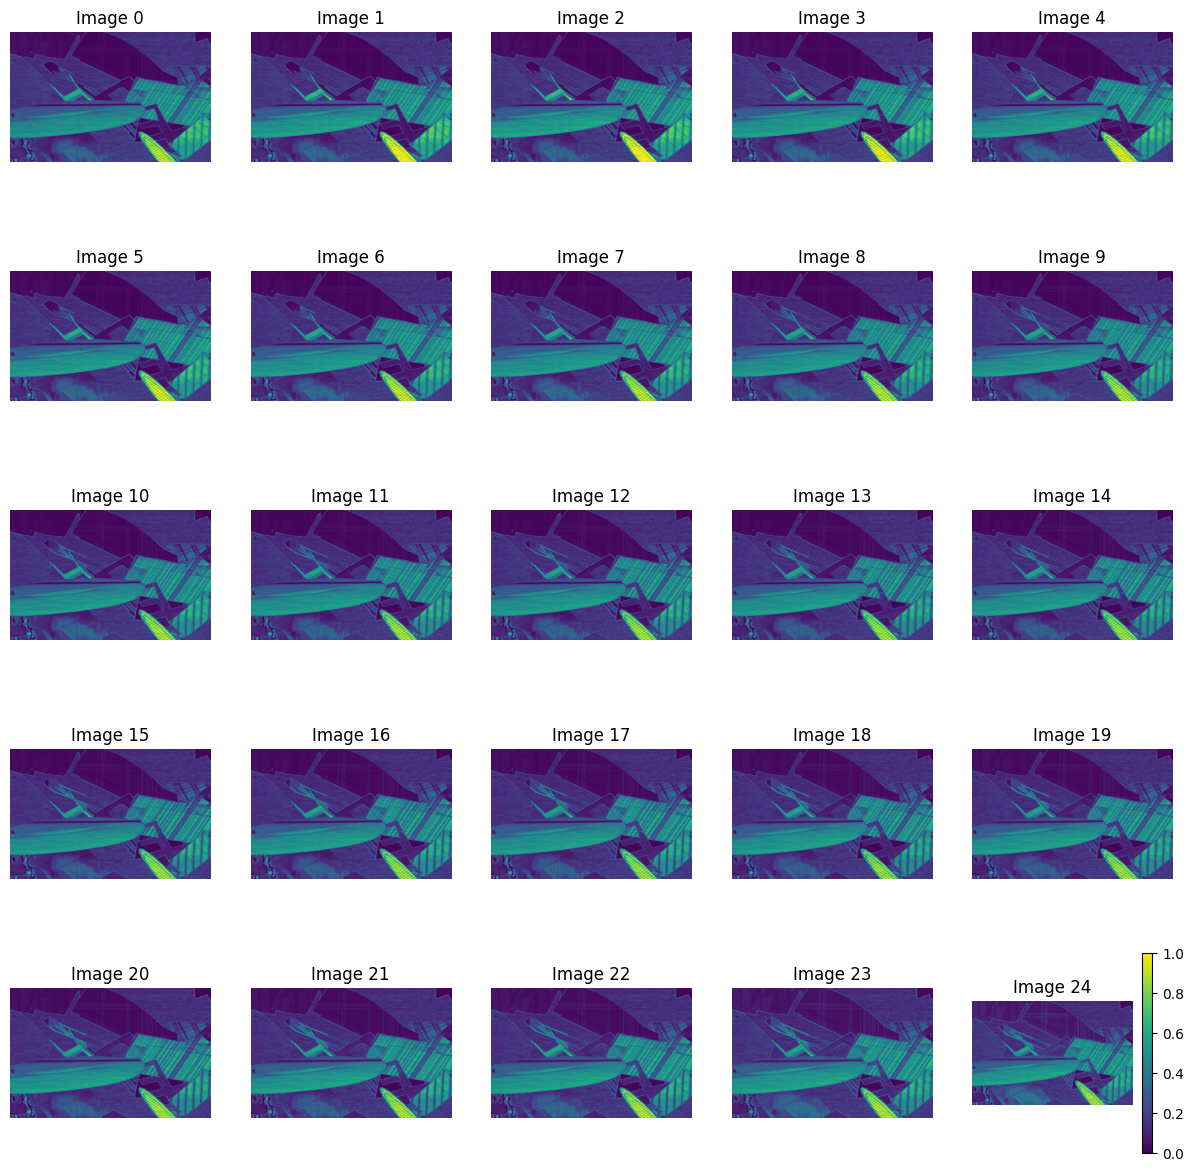

In [8]:
max_images_per_column = 5
num_columns = (W + max_images_per_column - 1) // max_images_per_column
plt.figure(figsize=(15, 3*num_columns))

for c in range(num_columns):
    start_index = c * max_images_per_column
    end_index = min(start_index + max_images_per_column, W)
    num_images = end_index - start_index
    
    for i in range(num_images):
        plt.subplot(num_columns, num_images, i + c * num_images + 1)
        plt.imshow(gt_hyp[:, :, i + start_index], vmin=0, vmax=1)
        plt.axis('off')
        plt.title(f"Image {i + start_index}")
        
        if i + start_index == W - 1:
            plt.colorbar()

In [9]:
occ = load_occ(1)

In [10]:
diff = abs(pred_hyp- gt_hyp)*occ.unsqueeze(dim = 2).numpy()

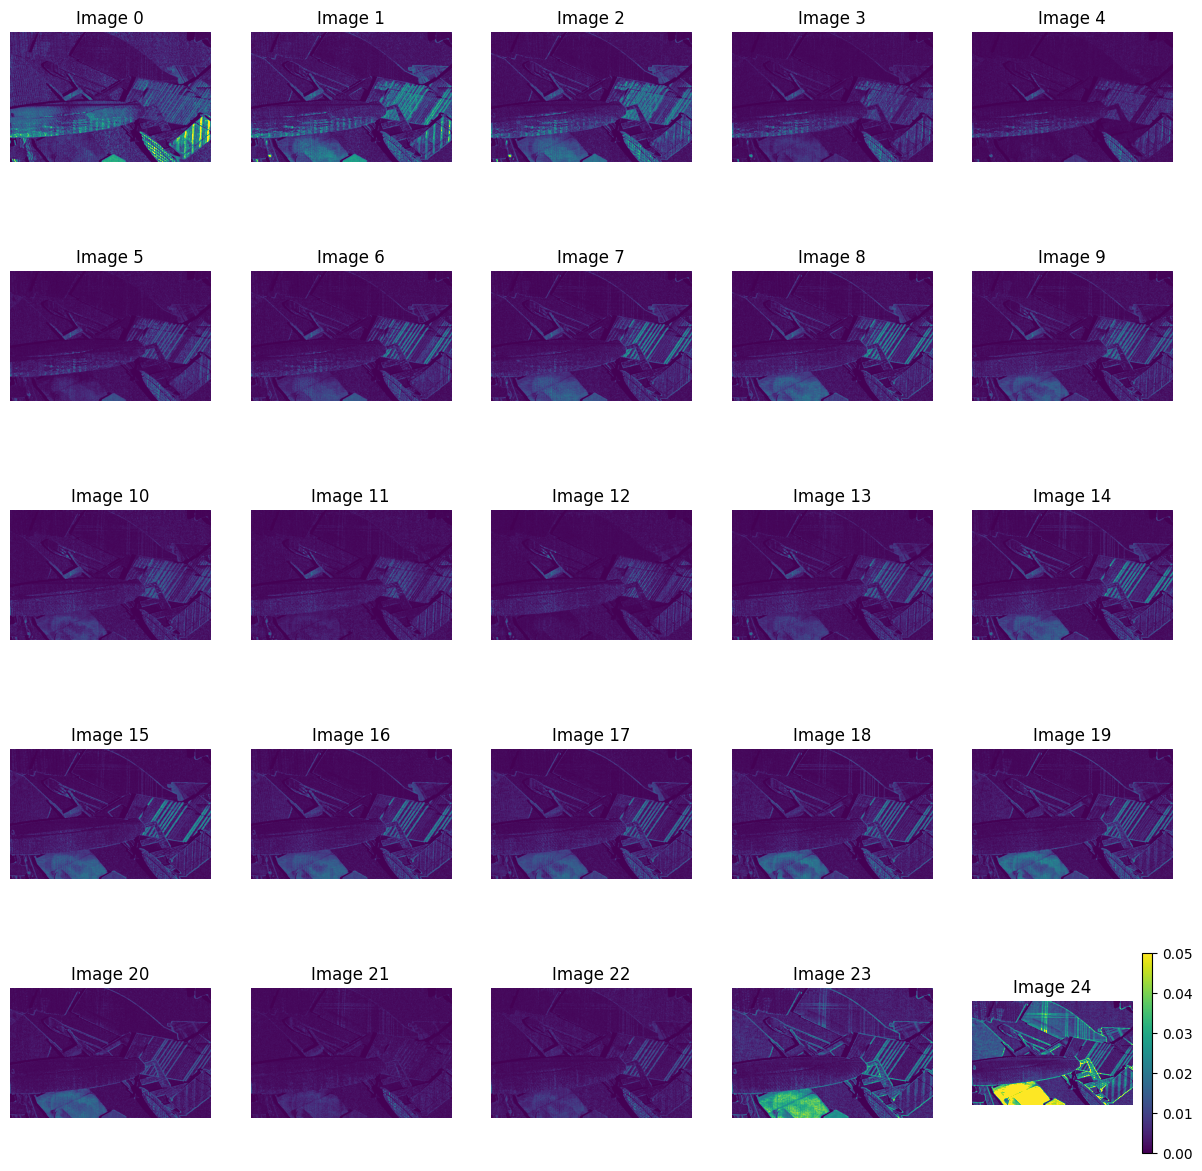

In [11]:
max_images_per_column = 5
num_columns = (W + max_images_per_column - 1) // max_images_per_column
plt.figure(figsize=(15, 3*num_columns))

for c in range(num_columns):
    start_index = c * max_images_per_column
    end_index = min(start_index + max_images_per_column, W)
    num_images = end_index - start_index
    
    for i in range(num_images):
        plt.subplot(num_columns, num_images, i + c * num_images + 1)
        plt.imshow(diff[:, :, i + start_index], vmin=0, vmax=0.05)
        plt.axis('off')
        plt.title(f"Image {i + start_index}")
        
        if i + start_index == W - 1:
            plt.colorbar()

### PSNR SAM

In [12]:
import cv2

In [13]:
device = 'cuda:7'

In [14]:
pred_hyp = np.load('/workspace/Scalable-Hyperspectral-3D-Imaging/prediction/prediction_hyp_1530.npy').astype(np.float32)
gt_hyp = np.load('/workspace/Scalable-Hyperspectral-3D-Imaging/prediction/ground_truth_hyp_1530.npy').astype(np.float32)

In [15]:
pred_hyp = pred_hyp.reshape(580,890,-1).transpose(2,0,1)
gt_hyp = gt_hyp.reshape(580,890,-1).transpose(2,0,1)

In [16]:
pred_hyp = pred_hyp*occ.numpy()
gt_hyp = gt_hyp*occ.numpy()

In [17]:
pred_hyp.shape, gt_hyp.shape

((25, 580, 890), (25, 580, 890))

In [18]:
psnr = cv2.PSNR(pred_hyp*255, gt_hyp*255)

In [19]:
psnr

42.521952276642935

#### unit vec

In [20]:
pred_hyp = pred_hyp.reshape(-1, 580*890)[2:-2]
gt_hyp = gt_hyp.reshape(-1, 580*890)[2:-2]

In [21]:
pred_hyp.shape

(21, 516200)

In [22]:
gt_norm = np.linalg.norm(gt_hyp, axis =0)
pred_norm = np.linalg.norm(pred_hyp, axis = 0)

In [23]:
len(gt_norm)

516200

In [24]:
for i in range(len(gt_norm)):
    if gt_norm[i] == 0.:
        gt_norm[i] = 1

In [25]:
for i in range(len(pred_norm)):
    if pred_norm[i] == 0.:
        pred_norm[i] = 1

In [26]:
(pred_norm == 0).sum()

0

In [27]:
gt_unit = gt_hyp / gt_norm
pred_unit = pred_hyp / pred_norm

In [28]:
cos = gt_unit*pred_unit

In [29]:
theta = cos.sum(axis=0)

In [30]:
theta_mean = theta.mean()

In [31]:
torch.set_printoptions(precision=10)

In [32]:
theta_mean

0.91792977

In [33]:
from skimage.metrics import structural_similarity as ssim 

In [34]:
pred_hyp = pred_hyp.reshape(-1, 580,890)
gt_hyp = gt_hyp.reshape(-1, 580,890)

In [35]:
score = ssim(pred_hyp, gt_hyp, data_range= gt_hyp.max() - gt_hyp.min())

In [36]:
score

0.9959561429705002

In [37]:
from basicsr.metrics.metric_util import reorder_image, to_y_channel
from basicsr.utils.registry import METRIC_REGISTRY

def _ssim(img1, img2):
    """Calculate SSIM (structural similarity) for one channel images.

    It is called by func:`calculate_ssim`.

    Args:
        img1 (ndarray): Images with range [0, 255] with order 'HWC'.
        img2 (ndarray): Images with range [0, 255] with order 'HWC'.

    Returns:
        float: ssim result.
    """

    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

In [38]:
def calculate_ssim(img1, img2, crop_border, input_order='HWC', test_y_channel=False):
    """Calculate SSIM (structural similarity).

    Ref:
    Image quality assessment: From error visibility to structural similarity

    The results are the same as that of the official released MATLAB code in
    https://ece.uwaterloo.ca/~z70wang/research/ssim/.

    For three-channel images, SSIM is calculated for each channel and then
    averaged.

    Args:
        img1 (ndarray): Images with range [0, 255].
        img2 (ndarray): Images with range [0, 255].
        crop_border (int): Cropped pixels in each edge of an image. These
            pixels are not involved in the SSIM calculation.
        input_order (str): Whether the input order is 'HWC' or 'CHW'.
            Default: 'HWC'.
        test_y_channel (bool): Test on Y channel of YCbCr. Default: False.

    Returns:
        float: ssim result.
    """

    assert img1.shape == img2.shape, (f'Image shapes are differnet: {img1.shape}, {img2.shape}.')
    if input_order not in ['HWC', 'CHW']:
        raise ValueError(f'Wrong input_order {input_order}. Supported input_orders are ' '"HWC" and "CHW"')
    img1 = reorder_image(img1, input_order=input_order)
    img2 = reorder_image(img2, input_order=input_order)
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    if crop_border != 0:
        img1 = img1[crop_border:-crop_border, crop_border:-crop_border, ...]
        img2 = img2[crop_border:-crop_border, crop_border:-crop_border, ...]

    if test_y_channel:
        img1 = to_y_channel(img1)
        img2 = to_y_channel(img2)

    ssims = []
    for i in range(img1.shape[2]):
        ssims.append(_ssim(img1[..., i], img2[..., i]))
    return np.array(ssims).mean()

In [39]:
pred_hyp.shape

(21, 580, 890)

In [40]:
calculate_ssim(pred_hyp, gt_hyp, 0, 'CHW')

0.9999971984800213

In [41]:
from torchmetrics.functional import structural_similarity_index_measure as ssim

In [42]:
pred_hyp = torch.tensor(pred_hyp.reshape(-1, 580,890), device = 'cuda:7').unsqueeze(dim = 0)
gt_hyp = torch.tensor(gt_hyp.reshape(-1, 580,890), device = 'cuda:7').unsqueeze(dim = 0)
score1 = ssim(pred_hyp, gt_hyp, data_range= gt_hyp.max() - gt_hyp.min())

In [43]:
score1

tensor(0.9969395399, device='cuda:7')